# 6. Rendering pipeline

## Overview

In this tuturial, we are going to see how to implement a custom rendering pipeline, including integrator's code. This is a crutial toturial for users who are interested in writing quick prototypes of rendering algorithms in Python, leveraging the JIT compiler to maintain high performances.

In order to avoid confusing users with complex concepts of physically based rendering and keep this tutorial accessible, we are going to implement a very basic integrator, that only computes direct illumination. Moreover, we will only rely on light sampling for constructing light paths, leaving topics such as BSDF sampling and MIS aside. It goes without saying that implementing those should be straighforward once familiar with this tutorial.

In contrast to the previous tutorial, this time we will rely on the sensor and film objects present in the scene to generate rays and store integrator samples. By doing so, every scene rendered using this pipeline can define the type of sensor, reconstruction filter, and film to be used for generating the final image.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Write a custom rendering pipeline</li>
  <li>Generate rays using the scene's sensor</li>
  <li>Implement a custom integrator</li>
  <li>Splat values to the film</li>
</ul>
    
</div>


### Step 1 - setup

You should now be familiar with the variant setup and scene loading routine that we have already used in previous tutorials.

In [1]:
# Add mitsuba and drjit to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../build/python')

In [2]:
import drjit as dr
import mitsuba as mi
mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../scenes/cbox.xml')

2022-02-14 16:30:13 INFO main [xml.cpp:1260] Loading XML file "../scenes/cbox.xml" with variant "llvm_ad_rgb"..

2022-02-14 16:30:13 INFO main [Scene] Embree ready. (took 19ms)

2022-02-14 16:30:13 INFO main [xml.cpp:1319] Done loading XML file "../scenes/cbox.xml" (took 26ms).

### Step 2 - prepare the pipeline

In order to build our custom rendering pipeline, we need to access the different objects provided in the scene (e.g. sensor, sampler, film). Note that we can of course decide to swap one of those with our own instances or custom code, e.g. using the `mitsuba.load_dict` as done in previous tutorials.

It is possible to define multiple sensors in a scene, and in this tutorial, we will always use the first one.

The `mitsuba.Film` class defines how samples generated by the integrator should be stored and developed into the final image. Crop regions are supported in Mitsuba and we therefore use the `crop_size` method to define the resolution of the pixel grid to render.

In Mitsuba, most film plugins expect the integrator to produce color values in RGB color space and provide an alpha and weight channel. It is the film's responsibility to accumulate the weights per pixel and later divide the pixel values by this weight to produce the final image.

While it is possible to define an arbitrary number of other extra channels (see [AOVs](...)),  in this tutorial we are only interested in rendering color images. Before using the film, it is required to call the `mitsuba.Film.prepare` method to register the extra channels to be expected by the film.

In [3]:
sensor = scene.sensors()[0]

film = sensor.film()
film_size = film.crop_size()

film.prepare([])

4

Monte-Carlo integration often produces noisy results due to the variance in the sampling methods. Therefore, it is necessary to compute many samples for every pixel in order to reduce this noise. Here we are going to compute 32 samples for every pixel in our image which will be averaged by the film later on.

Similar to [Tutorial 05](...), we need to seed and inform the sampler instance of the total number of samples (a.k.a. wavefront size).

In [4]:
spp = 32 # samples per pixel
wavefront_size = dr.hprod(film_size) * spp

sampler = sensor.sampler()
sampler.seed(0, wavefront_size)

### Step 3 - generate camera rays

Every sensor plugin implements the `sample_ray_differential` method to generate rays given a set of random numbers. The `sample2` argument of this method expects pixel location in fractional pixel coordinates. In order to ensure that every pixel receives the right amount of samples, we need to manually construct this array of 2D locations.

We start by generating a increasing sequence of the size of the wavefront, We then use integer division to get an increasing sequence of `spp` constant indices per pixel. Using a modulo operation and another integer division, we can construct a 2D array of pixel indices, where at least `spp` entries in the array correspond to every pixel. Finally, we add an random offset in $[0, 1]^2$ to those pixel indices to compute the final fractional pixel coordinates.

In [5]:
# Sample pixel locations
pixel_pos = dr.arange(mi.UInt32, wavefront_size)
pixel_pos //= spp
pixel_pos = mi.Vector2f(mi.Float(pixel_pos  % int(film_size[0])),
                        mi.Float(pixel_pos // int(film_size[0])))
pixel_pos += sampler.next_2d()

# Sample rays starting from the camera sensor
rays, weights = sensor.sample_ray_differential(
    time=0,
    sample1=sampler.next_1d(),
    sample2=pixel_pos / mi.Vector2f(film_size),
    sample3=0
)

### Step 4 - direct illumination integrator

The following code implements a basic direct illumination integrator using light sampling. After computing the intersection of the primary rays with the scene geometry, we evaluate potential emission at the surface interaction and perform light sampling. 

To do so, we first need to find out whether some of the rays have intersected an emitter object in the scene. This can be done by  querying `mitsuba.SurfaceInteraction.emitter`, which take the `scene` as argument as it should return its environment emitter (if any) for the missing rays. This method returns an array of `mitsuba.Emitter` pointers which can be used in the same way as a *scalar* emitter instance. For the more curious users, any subsequent method call on such arrays will perform a *vectorized virtual function call* under the hood. This is an important feature of the Dr.Jit library and you can learn more about it in the drjit [documentation](...).

We can evaluate the emission of all those emitters at once by calling the `eval` method. Note that for the rays that did not hit an emitter object, the corresponding entries in the `emitter` array of pointers will be `NULL` and the values resulting from virtual function calls for those entries will be set to zero. Therefore is it safe to directly accumulate the result of `emitter.eval` to `result`.

Light sampling can easily be performed by calling `sample_emitter_direction` which samples a location on a light source in the scene, performs the corresponding visibility test and return the associated irradiance value pre-divided by the sampling probability.

The last step is to evaluate the BSDF for the sampled emitter direction. Similarly to `emitter`, a BSDF pointer array associated to the surface interaction can be queried using `si.bsdf()`. We can then perform the evaluation of those BSDF and accumulate the resulting values multiplied by the sampled emission to the `result` array.

In [6]:
# Resulting color value
result = mi.Color3f(0)

# Intersect rays with the scene geometry
si = scene.ray_intersect(rays)
active = si.is_valid()

# Visible emitters
emitter = si.emitter(scene, active)
result += emitter.eval(si, active)

# Sample a direction from the intersection point towards an emitter
ds, emitter_val = scene.sample_emitter_direction(si, sampler.next_2d(), True, active)

# Evaluate the BSDF for the sampled emitter direction
bsdf = si.bsdf(rays)
wo = si.to_local(ds.d)
bsdf_val = bsdf.eval(mi.BSDFContext(), si, wo, active)

# Accumulate the product of the BSDF evaluation and the sampled emission
result += bsdf_val * emitter_val

### Step 5 - splatting onto the film

In order to splat the resulting color values to the film, we first need to instanciate an `ImageBlock`, responsible for storing pixel values and evaluating the pixel reconstruction filter. The `ImageBlock` class is an important component when implementing elaborate rendering pipelines (e.g. bucket rendering other, image-based parallel processes).

We first instanciate a `ImageBlock` object with the right size, number of channels and the reconstruction filter of the film. The constructor only allocated the memory region for the pixel data and it is therefore important to initialized those values to zero by calling `clear` before splatting the values.

We can then splat the color values at their respective pixel location using the `put` method and then add this image block to the film for later convertion to Bitmap.

In [7]:
# Construct a image block
block = mi.ImageBlock(
    film.crop_size(),
    offset=(0, 0),
    channel_count=4,
    rfilter=film.rfilter(),
    border=False
)

# Ensure the values in the allocated buffer are initialized to zero
block.clear()

# Splat the values to the ImageBlock at the corresponding pixel locations
block.put(pixel_pos, rays.wavelengths, result, alpha=mi.Float(1.0))

# Add this image block to the film for later convertion to Bitmap (e.g. HDR)
film.put_block(block)

### Step 6 - convert to sRGB

We use the `bitmap` method to develop the film into a raw Bitmap image, meaning that only the pixel weight was already applied but the pixel values are still represented in linear RGB color space. We can then leverage the `mitsuba.core.Bitmap.convert` method to apply gamma correction and convert our raw image to sRGB color space (using the sRGB gamma correction curve) as follow:

In [8]:
raw_image = film.bitmap(raw=True)
srgb_image = raw_image.convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, srgb_gamma=True)

Let's now have a look at the image we have produced in this tutorial! 

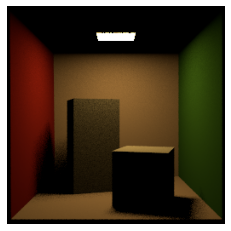

In [9]:
from matplotlib import pyplot as plt
plt.imshow(srgb_image); plt.axis('off');

### *Reference API*

- [<code>mitsuba.Bitmap</code>](...)
- [<code>mitsuba.Bitmap.convert</code>](...)
- [<code>mitsuba.ImageBlock</code>](...)
- [<code>mitsuba.ImageBlock.clear</code>](...)
- [<code>mitsuba.ImageBlock.put</code>](...)
- [<code>mitsuba.Film.put</code>](...)
- [<code>mitsuba.Film.bitmap</code>](...)
- [<code>mitsuba.Scene.ray_intersect</code>](...)
- [<code>mitsuba.Scene.sample_emitter_direction</code>](...)